In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings
from statsmodels.tsa.ar_model import AR
from IPython.display import Markdown as md
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima 
from pandas.tseries.offsets import DateOffset

In [2]:
inv_data=pd.read_csv('Final_invoice.csv',low_memory=False)

In [3]:
inv_data['month-yr']=pd.to_datetime(inv_data['Invoice Date']).dt.strftime('20%y-%m')

In [4]:
revenue_model=inv_data.groupby(['Model','month-yr']).agg({'Total Amt Wtd Tax.':['mean','count']})

In [5]:
revenue_model

Total Amt Wtd Tax.      
                             mean count
Model month-yr                         
207   2013-02            0.000000     1
      2013-04          399.560000     1
      2013-06        29459.690000     1
      2013-10         1916.330000     1
      2014-01         4386.080000     1
...                           ...   ...
ZEST  2016-06         1389.913571    28
      2016-07         1607.420250    40
      2016-08         6648.588571    35
      2016-09         2311.371333    30
      2016-10         4888.993636    55

[7506 rows x 2 columns]

In [6]:
revenue_model.columns=revenue_model.columns.droplevel()

In [7]:
revenue_model['revenue']=revenue_model['mean']*revenue_model['count']

In [8]:
revenue_model

mean  count    revenue
Model month-yr                                
207   2013-02       0.000000      1       0.00
      2013-04     399.560000      1     399.56
      2013-06   29459.690000      1   29459.69
      2013-10    1916.330000      1    1916.33
      2014-01    4386.080000      1    4386.08
...                      ...    ...        ...
ZEST  2016-06    1389.913571     28   38917.58
      2016-07    1607.420250     40   64296.81
      2016-08    6648.588571     35  232700.60
      2016-09    2311.371333     30   69341.14
      2016-10    4888.993636     55  268894.65

[7506 rows x 3 columns]

In [9]:
model_data=revenue_model.round(1).pivot_table(index=['month-yr'],columns=['Model'],values=['revenue'],fill_value=0,aggfunc='sum').reset_index()

In [10]:
model_data.columns=model_data.columns.droplevel()
model_data.rename(columns={'':'Month-yr'},inplace=True)

In [11]:
model_data['total_revenue']=model_data.iloc[:,1:].sum(axis=1)

In [12]:
model_data.head(5)

Model,Month-yr,207,3 SERIES,5 SERIES,500,6 SERIES,7 SERIES,800,A STAR,A4,...,XCENT,XENON XT,XUV 500,XYLO,YETI,Z4,ZEN,ZEN ESTILO,ZEST,total_revenue
0,2012-04,0.0,0.0,0.0,0.0,0.0,0.0,123133.5,7854.8,315.1,...,0.0,0.0,0.0,289312.7,0.0,0.0,79027.8,33912.5,0.0,8074167.1
1,2012-05,0.0,0.0,399.6,0.0,0.0,0.0,121783.2,2392.9,0.0,...,0.0,0.0,700.5,227977.1,0.0,0.0,54073.9,9911.7,0.0,8722166.6
2,2012-06,0.0,0.0,0.0,0.0,0.0,0.0,118818.7,11251.8,0.0,...,0.0,0.0,0.0,250102.1,0.0,0.0,161056.6,25037.4,0.0,9583730.5
3,2012-07,0.0,0.0,5550.0,0.0,0.0,0.0,201496.6,13606.9,349.7,...,0.0,0.0,0.0,455016.2,0.0,0.0,144173.0,38187.4,0.0,10232167.4
4,2012-08,0.0,0.0,0.0,299.9,0.0,0.0,164450.2,8840.4,0.0,...,0.0,0.0,4210.5,179911.4,0.0,0.0,132799.3,45499.5,0.0,8917274.6


In [13]:
time_series_data=model_data[['total_revenue','Month-yr']].sort_values(by='Month-yr')
time_series_data['Month-yr']=pd.to_datetime(time_series_data['Month-yr'])
time_series_data.set_index('Month-yr',inplace=True)

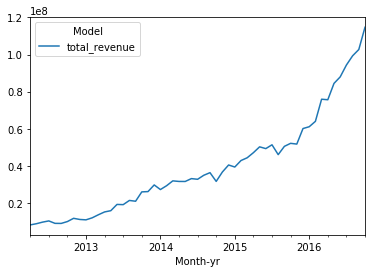

In [307]:
time_series_data.plot()

In [15]:
if adfuller(time_series_data.total_revenue)[1]<=0.55:
    print('data has stationarity')
else:
    print('data has No stationarity')

data has No stationarity


In [16]:
first_diff_order=time_series_data.diff(periods=1)
first_diff_order=first_diff_order[1:]

In [17]:
second_diff_order=first_diff_order.diff(periods=1)
second_diff_order=second_diff_order[1:]

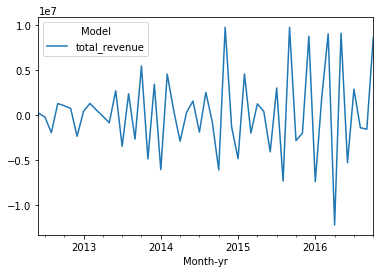

In [18]:
second_diff_order.plot()

In [19]:
if adfuller(second_diff_order)[1]<=0.55:
    print('data has stationarity')
else:
    print('data has No stationarity')

data has stationarity


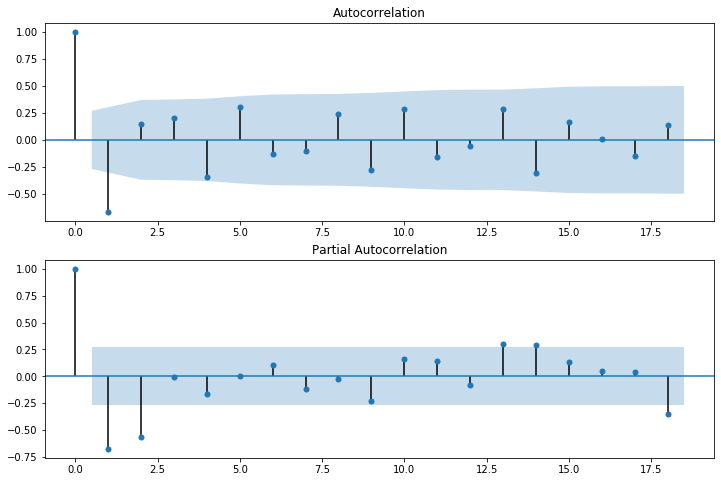

In [20]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(2,1,1)
fig=sm.graphics.tsa.plot_acf(second_diff_order,ax=ax1)
ax2=fig.add_subplot(2,1,2)
fig=sm.graphics.tsa.plot_pacf(second_diff_order,ax=ax2)
plt.show()

In [21]:
result = seasonal_decompose(time_series_data['total_revenue'],  
                            model ='multiplicative')

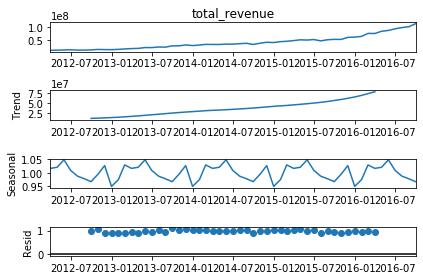

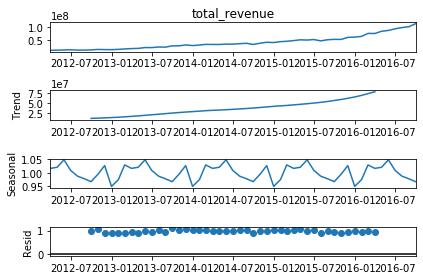

In [22]:
result.plot()

In [23]:
#split the data into train and test
X_train=time_series_data['total_revenue'].values[:len(time_series_data['total_revenue'])-9] # train size=27
X_test=time_series_data['total_revenue'].values[len(time_series_data['total_revenue'])-9:] #test size=9

In [68]:

p=d=q=range(0,10)
pdq=list(product(p,d,q))

warnings.filterwarnings('ignore')
aic_list={}
for params in pdq:
    try:
        model_arima=ARIMA(X_train,order=params)
        model_arima_fit=model_arima.fit()
        predictions_Arima=model_arima_fit.forecast(steps=9)[0]
        aic_list.update({params:np.sqrt(mean_squared_error(X_test,predictions_Arima))})
    except:
        continue

In [70]:
min_rmse=min(aic_list, key=aic_list.get)
print('Minimum rmse at : ',min_rmse)
arima=ARIMA(X_train,order=min_rmse)
arima_fit=arima.fit()
predictions_Arima=arima_fit.forecast(steps=9)[0]

Minimum rmse at :  (1, 2, 0)


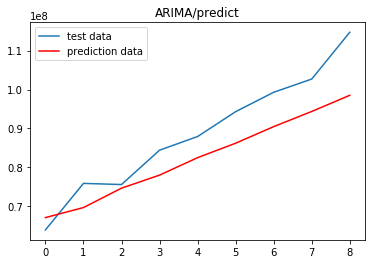

 aic score= 1442.26 

In [71]:
plt.plot(X_test)
plt.plot(predictions_Arima,color='red')
plt.title('ARIMA/predict')
plt.legend(['test data','prediction data'])
plt.show()
md(' aic score= {} '.format(round(arima_fit.aic,2)))

In [118]:
stepwise_fit = auto_arima(time_series_data['total_revenue'], start_p = 0, start_q = 0, 
                          max_p = 2, max_q = 2, m = 11,
                          start_P = 0, seasonal = True,D = 2, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True,
                          maxiter=100)     

Performing stepwise search to minimize aic
Fit ARIMA(0,2,0)x(0,2,1,11) [intercept=True]; AIC=1090.159, BIC=1094.461, Time=0.179 seconds
Fit ARIMA(0,2,0)x(0,2,0,11) [intercept=True]; AIC=1099.548, BIC=1102.416, Time=0.017 seconds
Fit ARIMA(1,2,0)x(1,2,0,11) [intercept=True]; AIC=1074.004, BIC=1079.740, Time=0.418 seconds
Near non-invertible roots for order (1, 2, 0)(1, 2, 0, 11); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,2,1)x(0,2,1,11) [intercept=True]; AIC=1083.652, BIC=1089.388, Time=0.250 seconds
Fit ARIMA(0,2,0)x(0,2,0,11) [intercept=False]; AIC=1103.841, BIC=1105.275, Time=0.013 seconds
Fit ARIMA(0,2,1)x(0,2,0,11) [intercept=True]; AIC=1086.360, BIC=1090.662, Time=0.042 seconds
Fit ARIMA(0,2,1)x(1,2,1,11) [intercept=True]; AIC=1074.130, BIC=1081.300, Time=0.638 seconds
Fit ARIMA(0,2,1)x(1,2,0,11) [intercept=True]; AIC=1072.494, BIC=1078.230, Time=0.291 seconds
Fit ARIMA(0,2,1)x(2,2,0,11) [intercept=True]; AIC=107

In [119]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   55
Model:             SARIMAX(2, 2, 1)x(2, 2, [], 11)   Log Likelihood                -523.230
Date:                             Sat, 11 Jul 2020   AIC                           1060.460
Time:                                     00:54:22   BIC                           1070.498
Sample:                                          0   HQIC                          1063.732
                                              - 55                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.102e+06   1.57e+06      0.700      0.484   -1.98e+06    4.19e+06
ar.L1         -0.9973      0.704     -1.416      0.157      -2.377       0.383
ar.L2         -0.6045      0.680     -0.889      0.374      -1.937       0.728
ma.L1         -0.4259      0.828     -0.514      0.607      -2.049       1.197
ar.S.L11      -1.1412      0.636     -1.794      0.073      -2.388       0.105
ar.S.L22      -0.5742      0.789     -0.728      0.467      -2.121       0.972
sigma2      4.858e+13      0.014   3.39e+15      0.000    4.86e+13    4.86e+13
===================================================================================
Ljung-Box (Q):                       15.17   Jarque-Bera (JB):                 1.07
Prob(Q):                              0.99   Prob(JB):                         0.59
Heteroskedasticity (H):               1.12   Skew:                            -0.14
Prob(H) (two-sided):                  0.87   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.15e+31. Standard errors may be unstable.
"""

In [260]:
#seasonal ARIMA
sarima=SARIMAX(X_train,order=(1, 2, 0),seasonal_order=(2, 2, 0, 11),trend='t')
sarima_fit=sarima.fit(disp=0)
predictions_sArima=sarima_fit.forecast(steps=9)

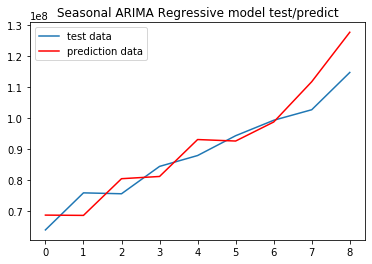

 aic score= 761.81 

In [261]:
plt.plot(X_test)
plt.plot(predictions_sArima,color='red')
plt.title('Seasonal ARIMA Regressive model test/predict')
plt.legend(['test data','prediction data'])
plt.show()
md(' aic score= {} '.format(round(sarima_fit.aic,2)))


In [315]:
dat=int(input())
dates=[time_series_data['total_revenue'].index[-1]+DateOffset(months=x)for x in range(0,dat)]
f_date=pd.DataFrame(index=dates[1:],columns=time_series_data.columns)
dataset=pd.concat([time_series_data,f_date])
predictions_sArima=sarima_fit.predict(start=55,end=dataset.shape[0]-1)
dataset=dataset.drop(index=dataset.index,inplace=True)

20
